## Colab Notebook created for ARAP module at UPC ETSETB.

Authors: Juan José Nieto, Margarita Cabrera-Bean, Josep Vidal

Student: [Àlex Batlle Casellas](mailto:alex.batlle@estudiantat.upc.edu)

# WINDY GRID WORLD
[Open to access description of tasks](https://drive.google.com/file/d/1wVWxRwIfRSfhdicwuWKSorav-BmC7Thh/view?usp=sharing)

1. Complete the code for each algorithm (Sarsa, Q-Learning, Expected Sarsa and Double Q-Learning).
2. Modify the environment creatively following the description of tasks document


## Library imports

In [ ]:
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import altair as alt
import pandas as pd
from random import random, randint
import matplotlib.pyplot as plt
algs = ['SARSA', 'Q-LEARNING', 'EXPECTED SARSA', 'DOUBLE Q-LEARNING']

## Original GridWorld implementation

In [ ]:
class GridWorld():
    def __init__(self):
        self.N_ROWS = 10
        self.N_COLUMNS = 10
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 2000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]

        self.N_ACTIONS = len(self.ACTIONS)
        
        # Define inital and final state
        self.INI_STATE = 6
        self.FIN_STATE = 76

        # Define wind for each row and column
        self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        self.WIND_H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes    
        self.V_FUN = np.zeros(self.N_STATES)


    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return state[1]*self.N_COLUMNS + state[0]


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]

        row = max(0, x + ax + self.WIND_V[y])
        row = min(self.N_ROWS-1, row)
        col = max(0, y + ay + self.WIND_H[x])
        col = min(self.N_COLUMNS-1, col)
        
        next_state = (row, col)

        next_state = self.get_state(next_state)

        if next_state == self.FIN_STATE:
            return next_state, 0
        return next_state, -1

    '''
    Performs greedy policy. With prob 1-epsilon pick action
    belonging to maximum action-value. With prob epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)
        
        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}
        
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''

    # WARNING: Note that some methods use the input variable: action and others do not
    
    def sarsa(self, state, action):
        
        # sarsa uses greedy policy for next action too

        # TODO -- DONE
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)
        self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, next_action])
        #
        return next_state, next_action

    def q_learning(self, state, action):

        # q-learning always pick next_action with maximum action-value (q-value)

        # TODO
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)
        greedy_action = np.argmax(self.Q_FUN[next_state])
        self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, greedy_action])
        #
        return next_state, next_action

    def expected_sarsa(self, state, action):
        
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state

        # TODO
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state)
        greedy_action = np.argmax(self.Q_FUN[next_state])
        # We are using Expected SARSA with epsilon greedy, hence the weight for
        # each action depends on the action being optimal or not
        update_for_Q = sum([self.Q_FUN[next_state, a]*(1-self.EPSILON+self.EPSILON/self.N_ACTIONS if a == greedy_action else self.EPSILON/self.N_ACTIONS) for a in range(self.N_ACTIONS)])
        self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*update_for_Q)
        #
        return next_state, next_action

    def double_q_learning(self, state, action):
        # Choose action taking into account both Q_FUNs

        # With 50% we will update Q_FUN or Q_FUN2. In either case, the actual q-value taken when computing the td_target
        # is given by the other Q_FUN, but we use the function we are updating to choose the next_action.

        # TODO
        next_state, reward = self.next_position(state, action)
        next_action = self.greedy_policy(next_state, double=True)
        
        # We are using Double Q-Learning with epsilon greedy
        
        if random() < 0.5:
            greedy_action_in_Q1 = np.argmax(self.Q_FUN[next_state])
            update_for_Q1 = self.Q_FUN2[next_state, greedy_action_in_Q1]
            self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*update_for_Q1)
        else:
            greedy_action_in_Q2 = np.argmax(self.Q_FUN2[next_state])
            update_for_Q2 = self.Q_FUN[next_state, greedy_action_in_Q2]
            self.Q_FUN2[state, action] = (1 - self.ALPHA)*self.Q_FUN2[state, action] + self.ALPHA*(reward + self.GAMMA*update_for_Q2)        
        #
        return next_state, next_action

    def deterministic_policy(self):
        max_steps = 50
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < max_steps:
            

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action)
            state = next_state
            steps += 1

            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

        trajectory[s[0], s[1]] = 0
        if steps == max_steps:
            steps = 'inf'
        return trajectory, steps


## Plot functions

In [ ]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def general_plot(vf_matrix, counts, first_policy, optimal_policy, determ_policy, steps, grid):
    fig, ax = plt.subplots(5, len(vf_matrix), figsize=(20, 20))
    fig.tight_layout(pad=2.5)

    X = np.arange(0, 10, 1)
    Y = np.arange(0, 10, 1)

    s = 0.05
    actions = grid.ACTIONS
    
    r,t = grid.get_XY(grid.INI_STATE)
    w,e = grid.get_XY(grid.FIN_STATE)

    ini_pad_y = (grid.N_ROWS - r)*2-1
    g_pad_y = (grid.N_ROWS - w)*2-1

    ini_pad_x = t*2+1
    g_pad_x = e*2+1
    
    ini_pad_x = s*ini_pad_x-s/2
    ini_pad_y = s*ini_pad_y-s/2

    g_pad_x = s*g_pad_x-s/2
    g_pad_y = s*g_pad_y-s/2

    for i, data in enumerate([vf_matrix, counts, first_policy, optimal_policy, determ_policy]):
        for j, d in enumerate(data):
            if i==0:
                sns.heatmap(d, cmap='coolwarm', ax=ax[i, j])
                conf = {'title': '{} VALUE FUNCTION'.format(algs[j])}
                insert_labels(conf, ax[i, j])
            elif i==1:
                conf= {
                    'title': 'Number of steps in each episode',
                    'xlabel': 'Episode #',
                    'ylabel': 'number of steps'
                }
                ax[i,j].plot(d)
                insert_labels(conf, ax[i, j])
            elif i==2 or i==3:
                U = np.array([[actions[y][0] for y in x] for x in d])
                V = np.array([[actions[y][1] for y in x] for x in d])

                q = ax[i,j].quiver(X, Y, V, U*-1)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': '{} Policy'.format('First' if i==2 else 'Final')}
                insert_labels(conf, ax[i,j])
                
            elif i==4:
                U = np.array([[actions[y][0] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])
                V = np.array([[actions[y][1] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])

                q = ax[i,j].quiver(X, Y, V, U*-1, scale=5.3, scale_units='inches')
                
                ax[i,j].text(ini_pad_x, ini_pad_y, 'INI', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].text(g_pad_x, g_pad_y, 'G', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': 'Deterministic Policy. # Steps: {}'.format(steps[j])}
                insert_labels(conf, ax[i,j])






# ALGORITHMS:
1 -> SARSA

2 -> Q-LEARNING

3 -> EXPECTED SARSA

4 -> DOUBLE Q-LEARNING

# STANDARD WINDY GRID WORLD: One run testing

In [ ]:

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []

for ALGORITHM in range(1,5):
    grid = GridWorld()
    counts = []
    for i in range(grid.N_EPISODES):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        n_count = 0

        while not state == grid.FIN_STATE:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action)

            action = next_action
            state = next_state

            n_count += 1
        if i==0:
            first_policy = grid.compute_actions()
        counts.append(n_count)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)


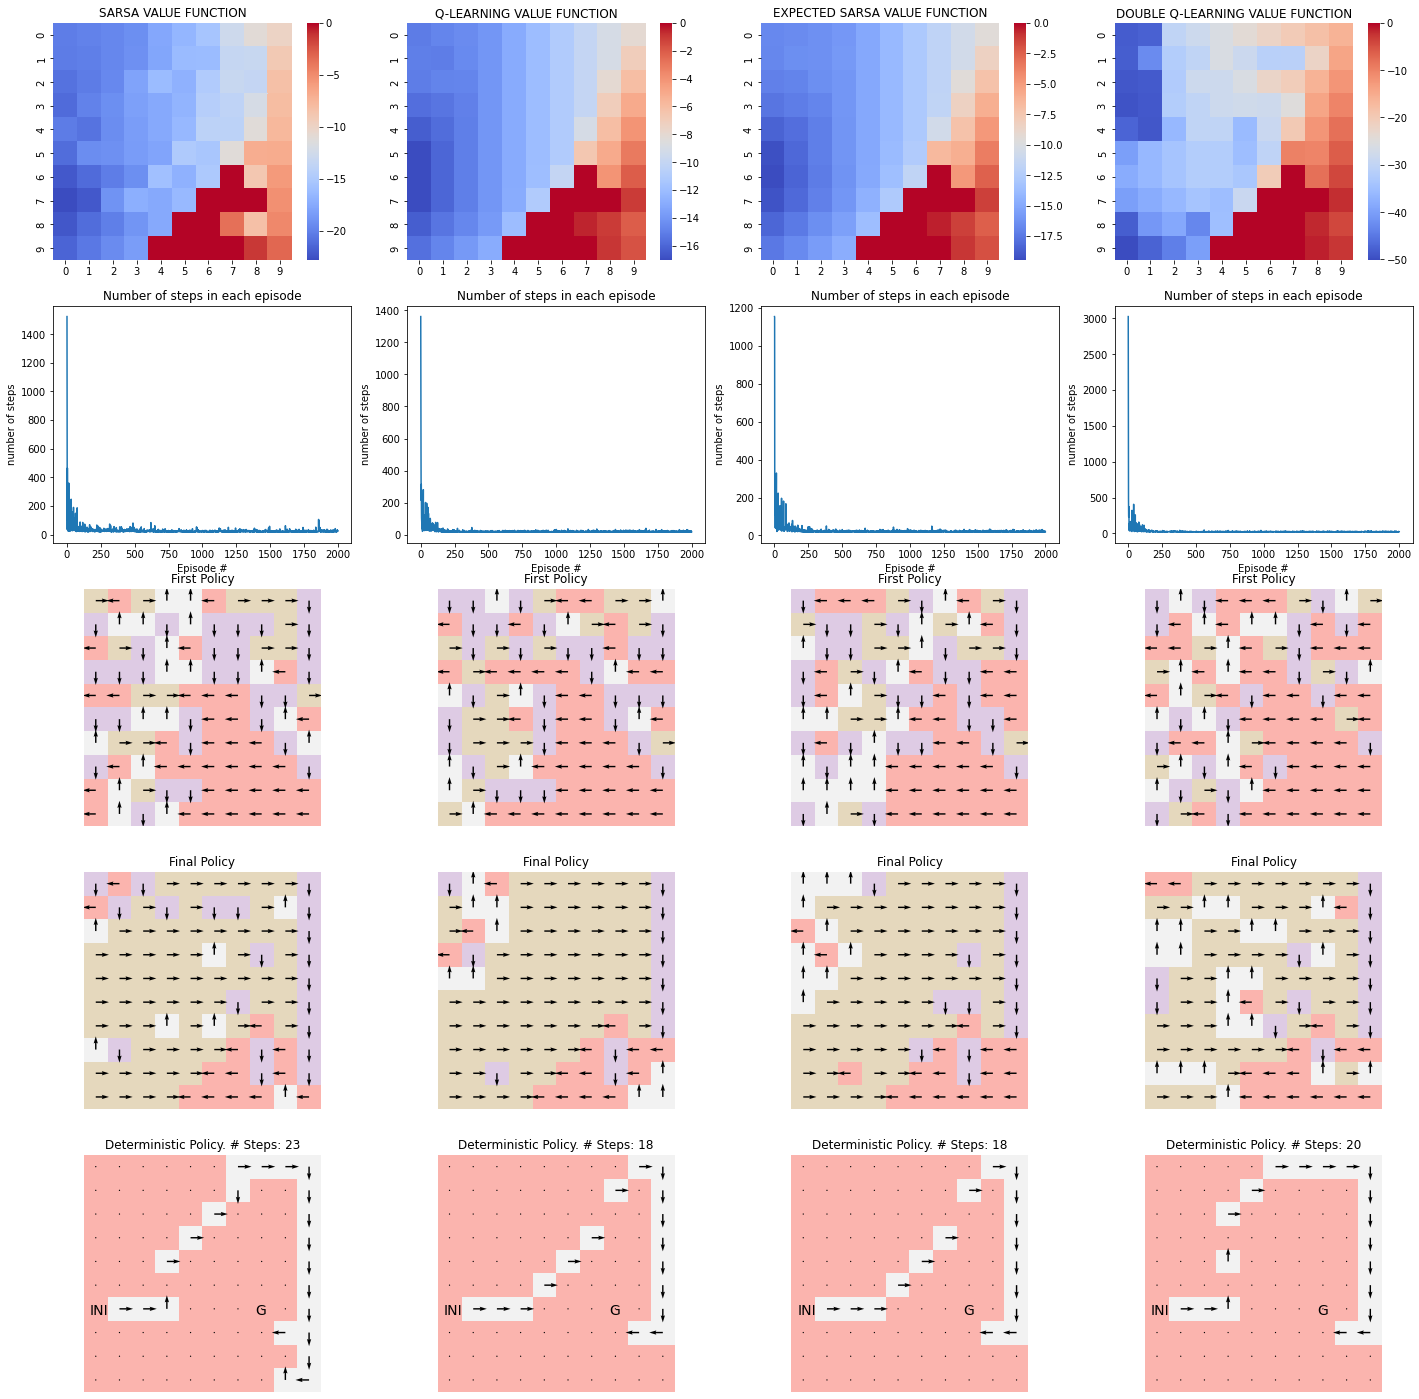

In [ ]:
general_plot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid)

# Algorithms Analysis for Gridworld

For our first task in this lab, we want to analyze several runs of every algorithm in our list (SARSA, Q-Learning, Expected SARSA and Double Q-Learning) and see which one performs better, which one has the best mean number of episodes until convergence, etc. To do this, we define the following function, which will return the data we need to analyze.

In [ ]:
def test_algorithms(n_runs: int = 50):

    algorithms = ['sarsa', 'q-learning', 'expected sarsa', 'double q-learning']
    total_optimal_runs = {name: 0 for name in algorithms}
    average_steps_per_run = {name: 0 for name in algorithms}
    mean_episodes_until_convergence = {name: 0 for name in algorithms}
    total_episodes_until_convergence = []
    for run in tqdm(range(n_runs), desc='Runs Progress'):
        # average_steps_this_run = []
        run_episodes_until_convergence = []
        total_steps = []
        for ALGORITHM in algorithms:
            grid = GridWorld()
            number_of_episodes_until_convergence = grid.N_EPISODES
            previous_policy = grid.compute_actions()
            policy = grid.compute_actions()
            algorithm_has_converged = False
            average_steps_per_episode = 0
            for episode in range(grid.N_EPISODES):
                policy_stable = True
                state = grid.INI_STATE
                action = grid.greedy_policy(state)
                steps = 0

                while not state == grid.FIN_STATE:

                    if ALGORITHM == 'sarsa':
                        next_state, next_action = grid.sarsa(state, action)
                    elif ALGORITHM == 'q-learning':
                        next_state, next_action = grid.q_learning(state, action)
                    elif ALGORITHM == 'expected sarsa':
                        next_state, next_action = grid.expected_sarsa(state, action)
                    elif ALGORITHM == 'double q-learning':
                        next_state, next_action = grid.double_q_learning(state, action)

                    action = next_action
                    state = next_state
                    steps += 1
                
                # incremental implementation of the mean
                average_steps_per_episode += (steps-average_steps_per_episode)/(episode+1)

                # Upon end of episode, we compute the actions for the newest
                # policy and compare the actions
                previous_policy = policy
                policy = grid.compute_actions(double = ALGORITHM == 'double q-learning')
                for (action_old, action_new) in zip(previous_policy, policy):
                    # If any action is different, we have not yet reached the
                    # optimal policy, hence we are not in a stable point
                    if action_old != action_new:
                        policy_stable = False
                        break
                if policy_stable and not algorithm_has_converged:
                    number_of_episodes_until_convergence = episode
                    algorithm_has_converged = True
                if episode == 0:
                    first_policy = policy
            run_episodes_until_convergence.append(number_of_episodes_until_convergence)
            # average_steps_this_run.append(average_steps_per_episode)
            
            v_fun = grid.compute_v_fun()
            vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
            first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
            final_policy = grid.compute_actions(double=True)
            final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
            determ_policy, steps = grid.deterministic_policy()

            total_steps.append(steps)
            if steps == 18:
                # After the whole run (grid.N_EPISODES episodes) we have learnt
                # the optimal policy, hence this is an optimal run
                total_optimal_runs[ALGORITHM] += 1/n_runs
            average_steps_per_run[ALGORITHM] += (average_steps_per_episode-average_steps_per_run[ALGORITHM])/(run+1)
        total_episodes_until_convergence.append(run_episodes_until_convergence)


    eps = np.mean(total_episodes_until_convergence, axis=0)
    for i in range(4):
        mean_episodes_until_convergence[algorithms[i]] = eps[i]

    return {'optimal_runs': total_optimal_runs, 'convergence': mean_episodes_until_convergence, 'average_steps': average_steps_per_run}


As one can observe, we consider that an algorithm has converged to a policy if in two consecutive episodes, the policy does not change at all. This makes sense, as we have seen in class that every update of these algorithms always improves the original policy, that is, if it is not optimal, some actions change. We now test the defined function and plot the results:

In [ ]:
data = test_algorithms(100)
optimal_runs_data = data['optimal_runs']
convergence_data  = data['convergence']
steps_data        = data['average_steps']

import altair as alt
import pandas as pd

df_optimal = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(optimal_runs_data.values())})
ch1 = alt.Chart(df_optimal).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(format='%', title='(average) Percentage of optimal runs'))
).properties(
    width=400
)

df_convergence = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(convergence_data.values())})
ch2 = alt.Chart(df_convergence).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(title='(average) Episodes until convergence'))
).properties(
    width=400
)

df_steps = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(steps_data.values())})
ch3 = alt.Chart(df_steps).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(title='(average) Steps per episode'))
).properties(
    width=400
)

ch1 | ch2 | ch3

Runs Progress:   0%|          | 0/100 [00:00<?, ?it/s]

alt.HConcatChart(...)

We observe that in the 100% of runs, the agent ends up deducing the optimal route when using expected SARSA and Q-Learning, while when using Double Q-Learning or SARSA, the results are worse, and only perform optimally in 9% and 24% of runs, respectively.

In terms of convergence of the action-value function, we can see that Q-Learning is the fastest to converge, but all algorithms converge around the 200 episodes; this is 10% of the number of episodes ran per run, which confirms what we could intuitively deduce from the results of a single run. In those, we can see how all four algorithms stay in similar number of steps per episode from episode ~250 on.

With the 100-run analysis, we can also see how many steps do the algorithms take before getting to the terminal state, on average. The results are all around 30, which we could not particularly deduce from the one-run analysis. This is because the number of steps per episode in just one run has a lot of noise (any estimate, actually, has a lot of noise with just one run), and by averaging, we are getting rid of it. In any case, we can see that the minimum across all considered algorithms is achieved with Q-Learning, but this is not necessarily representative of anything, as all four algorithms are pretty close to each other.

# Custom GridWorld

## Custom GeneralPlot function

Here we implement the `general_plot` function, but with the particular idiosyncrasies of the customized windy GridWorld that we will see later.

In [ ]:
'''Insert title, and axis labels to plots'''
def insert_labels(labels, ax):
    if 'title' in labels:
        ax.set_title(labels['title']) 
    if 'xlabel' in labels:
        ax.set_xlabel(labels['xlabel']) 
    if 'ylabel' in labels:
	    ax.set_ylabel(labels['ylabel'])

def GeneralPlot(vf_matrix, counts, first_policy, optimal_policy, determ_policy, steps, grid, maps):
    fig, ax = plt.subplots(6, len(vf_matrix), figsize=(20, 20))
    fig.tight_layout(pad=2.5)

    X = np.arange(0, 20, 1)
    Y = np.arange(0, 20, 1)

    s = 0.05
    actions = grid.ACTIONS
    
    r,t = grid.get_XY(grid.INI_STATE)
    w,e = grid.get_XY(grid.FIN_STATE)

    ini_pad_y = (grid.N_ROWS - r)*2-1
    g_pad_y = (grid.N_ROWS - w)*2-1

    ini_pad_x = t*2+1
    g_pad_x = e*2+1
    
    ini_pad_x = s*ini_pad_x-s/2
    ini_pad_y = s*ini_pad_y-s/2

    g_pad_x = s*g_pad_x-s/2
    g_pad_y = s*g_pad_y-s/2

    for i, data in enumerate([vf_matrix, counts, first_policy, optimal_policy, determ_policy, maps]):
        for j, d in enumerate(data):
            if i == 0:
                sns.heatmap(d, cmap='coolwarm', ax=ax[i, j])
                conf = {'title': '{} VALUE FUNCTION'.format(algs[j])}
                insert_labels(conf, ax[i, j])
            elif i == 1:
                conf= {
                    'title': 'Number of steps in each episode',
                    'xlabel': 'Episode #',
                    'ylabel': 'number of steps'
                }
                ax[i,j].plot(d)
                insert_labels(conf, ax[i, j])
            elif i == 2 or i == 3:
                U = np.array([[actions[y][0] for y in x] for x in d])
                V = np.array([[actions[y][1] for y in x] for x in d])

                q = ax[i,j].quiver(X, Y, V, U*-1)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': '{} Policy'.format('First' if i==2 else 'Final')}
                insert_labels(conf, ax[i,j])
                
            elif i == 4:
                U = np.array([[actions[y][0] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])
                V = np.array([[actions[y][1] if determ_policy[j][l,p]==1 else 0 for p,y in enumerate(x)] for l,x in enumerate(optimal_policy[j])])

                q = ax[i,j].quiver(X, Y, V, U*-1, scale=5.3, scale_units='inches')
                
                # ax[i,j].text(ini_pad_x, ini_pad_y, 'INI', fontsize=14, transform=ax[i,j].transAxes)
                # ax[i,j].text(g_pad_x, g_pad_y, 'G', fontsize=14, transform=ax[i,j].transAxes)
                ax[i,j].imshow(d, cmap=plt.cm.Pastel1)

                ax[i,j].axis('off')
                conf= {'title': 'Deterministic Policy. # Steps: {}'.format(steps[j])}
                insert_labels(conf, ax[i,j])
            elif i == 5:
                ax[i,j].imshow(d)
                ax[i,j].axis('off')
                conf = {'title': 'map for alg {}'.format(algs[j])}
                insert_labels(conf, ax[i,j])





## Map creation code

The objective of our custom modification of Gridworld is to "climb a mountain" with concentric walls and wind. In terms of rewards, this is:
- The reward of each cell is more negative the closer we get to the center (the peak of the mountain).
- Walls do not have any reward, and any time the agent bumps into one, it will get thrown back to its previous state and given a very punishing reward.
The map will look like the following one:

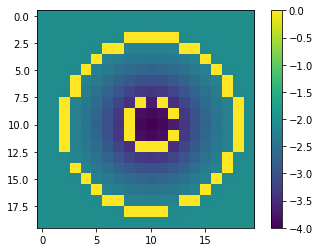

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# from random import random
# dim = 20
walls = [2, 8]
WALL_REWARD = 0

def fun(x: int, y: int, dim: int = 20):
    q = ((x-dim/2)/(0.2*dim))**2+((y-dim/2)/(0.35*dim))**2
    return -2-2*np.exp(-1.5*(((x-dim/2)/(0.3*dim))**2+((y-dim/2)/(0.3*dim))**2))

def has_wall(x: float, epsilon: float = 0.4):
    for wall in walls:
        if abs(x - wall) < epsilon:
            return True, wall
    return False, None

def generate_map(function, dim=20, show: bool = False):
    map = [[function(x,y) for y in range(dim)] for x in range(dim)]
    walls_XY = {w: [] for w in walls}
    for i, row in enumerate(map):
        for j, elem in enumerate(row):
            wall, radius = has_wall(np.sqrt((i-dim/2)**2 + (j-dim/2)**2))
            if wall:
                map[i][j] = WALL_REWARD
                walls_XY[radius].append((i, j))
    even_wall = False
    for wall in walls:
        wall_positions = walls_XY[wall]
        # n = randint(wall, 4*wall)
        n = 2
        for i in range(n):
            # idx = int(random()*len(wall_positions))
            idx = len(wall_positions)-2**(4*i) if even_wall else 2**(4*i)
            x, y = wall_positions[idx%len(wall_positions)]
            map[x][y] = function(x, y)
            del wall_positions[idx%len(wall_positions)]
        even_wall = not even_wall
    if show:
        plt.imshow(map)
        plt.colorbar()
    return map, walls_XY

_ = generate_map(fun, show=True)

## Custom GridWorld implementation:

In order to meet our specifications, we create the following class, which implements the mountain world. We already give it parameters to turn the wind or the wind evolution off, as we will see later that changing wind hinders significantly the ability of the algorithms to learn a good path to the peak. We will set the initial state to be the top-right corner of the grid, which is the most opposite to the holes in the outermost wall of the mountain.

In [ ]:
class MountainWorld():
    def __init__(self, _wind: bool = False, _changing_wind: bool = False):
        self.has_wind = _wind
        if self.has_wind:
            self.changing_wind = _changing_wind
        self.dim = 20
        self.N_ROWS = self.dim
        self.N_COLUMNS = self.dim
        self.N_STATES = self.N_ROWS * self.N_COLUMNS

        # Define parameters
        self.GAMMA = 1
        self.ALPHA = 0.5
        self.EPSILON = 0.1
        self.N_EPISODES = 1000

        # left/down/right/up action
        self.ACTIONS = [(0, -1), (1, 0), (0, 1), (-1, 0)]

        self.N_ACTIONS = len(self.ACTIONS)
        
        # Define inital and final states
        self.INI_STATE = self.get_state([0, 19])
        self.FIN_STATE = self.get_state([self.dim/2, self.dim/2])

        # Calculate Wall states
        self.WALL_STATES = []
        self.rewards, self.wall_list = generate_map(fun, self.dim)
        for radius in self.wall_list:
            for wall_xy in self.wall_list[radius]:
                self.WALL_STATES.append(self.get_state(wall_xy))

        self.MAX_TIME_STEPS = 1000

        # Define wind for each row and column
        # self.WIND_V = [0, 0, 0, -1, -1, -1, -2, -2, -1, 0]
        # self.WIND_H = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

        if self.has_wind:
            self.MAX_WIND_STRENGTH = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
        else:
            self.MAX_WIND_STRENGTH = [0 for _ in range(self.N_ROWS)]

        # Define action-value function
        self.Q_FUN = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define second action-value function for double q-learning
        self.Q_FUN2 = np.zeros((self.N_STATES, self.N_ACTIONS))
        # Define state-value function only for plotting purposes
        self.V_FUN = np.zeros(self.N_STATES)

    def get_world_map(self):
        return self.rewards

    def get_world_walls(self):
        return self.wall_list
    
    '''
    Get the wind at each state at each time step. In the event that the world
    was initialized with certain parameters, this wind will vary as a sine wave,
    first it will come from one side of the grid and then from the other one.

    wind(x, y, t) = sin(constant*t)                [provides wind "direction"]
                   *strength(x, y)                 [provides wind strength]
    '''
    def wind(self, state, time_step):
        if not self.has_wind:
            return 0
        elif self.changing_wind:
            (_, col) = self.get_XY(state)
            strength_multiplier = np.sin(time_step*np.pi/2)
            strength = self.MAX_WIND_STRENGTH[col]
            return strength_multiplier*strength
        else:
            (_, col) = self.get_XY(state)
            return self.MAX_WIND_STRENGTH[col]

    ''' Convert state s from scalar to coordinates x,y '''
    def get_XY(self, state):
        return (state % self.N_ROWS, int(state / self.N_ROWS))

    ''' Convert coordinates x,y to scalar state '''
    def get_state(self, state):
        return int(state[1]*self.N_COLUMNS + state[0])


    '''
    Computes next state and reward

    Params:
        - int: state in {0,..., N_STATES-1}
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: reward
    '''
    def next_position(self, state, action, time_step):

        (x,y) = self.get_XY(state)
        # x is the row number and y is the column number
        (ax, ay) = self.ACTIONS[action]


        row = int(max(0, x + ax + self.wind(state, time_step)))
        row = int(min(self.N_ROWS-1, row))
        col = int(max(0, y + ay))
        col = int(min(self.N_COLUMNS-1, col))

        row_without_wind = max(0, x + ax)
        row_without_wind = min(self.N_ROWS-1, row_without_wind)

        # Preventive wall check: agents cannot go through walls
        if self.get_state((row_without_wind, col)) in self.WALL_STATES:
            return state, -100
            


        next_state = (row, col)
        next_state = self.get_state(next_state)


        # We check for the following state not to be a wall, and in the event
        # that it is, we return the previous state and a punishing reward.
        if next_state in self.WALL_STATES:
            return state, -100

        # We also check if the following state is the final one, and if it is,
        # we compensate the algorithm with a big positive reward.
        if next_state == self.FIN_STATE:
            return next_state, 50
        
        # For all of the other states, the rewards are pre-computed.
        return next_state, self.rewards[row][col]

    '''
    Performs greedy policy. With prob 1-epsilon pick action
    belonging to maximum action-value. With prob epsilon
    pick a random action.

    Params:
        - int: state in {0,..., N_STATES-1}
        - bool: double, indicates whether we are using double q-learning or not
    Returns:
        - int: action in {0,..., N_ACTIONS-1}
    '''
    def greedy_policy(self, state, double=False):

        action = np.argmax(self.Q_FUN[state])
        if double:
            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state])

        if random() < self.EPSILON:
            action = randint(0, self.N_ACTIONS - 1)
        
        return action

    '''
    Compute state-value function

    Returns:
        - list: V_FUN
    '''
    def compute_v_fun(self):
        for i, action_values in enumerate(self.Q_FUN):
            self.V_FUN[i] = np.max(self.Q_FUN[i] + self.Q_FUN2[i])  # QFUN2[i] will be != 0 only in Double Q-Learning
        return self.V_FUN

    '''
    Compute actions taken in each state.

    Params:
        - boolean: double, indicates whether we are using double q-learning or not
    Returns:
        - list: actions, one for each state
    '''
    def compute_actions(self, double=False):
        actions = []
        for s in range(self.N_STATES):
            if double:
                actions.append(np.argmax(self.Q_FUN[s] + self.Q_FUN2[s]))
            else:
                actions.append(np.argmax(self.Q_FUN[s]))

        return actions

    '''
    The following functions are the different algorithms we will try.
    Basically we do two things:
        1. Compute next_state and next_action
        2. Update action-values (Q_FUN)

    Params:
        - int: state in {0,..., N_STATES-1}
        - int: action in {0,..., N_ACTIONS-1}
        
    Returns:
        - int: next_state in {0,..., N_STATES-1}
        - int: next_action in {0,..., N_ACTIONS-1}
    '''

    # WARNING: Note that some methods use the input variable: action and others do not
    
    def sarsa(self, state, action, time_step):
        
        # sarsa uses greedy policy for next action too

        next_state, reward = self.next_position(state, action, time_step)
        next_action = self.greedy_policy(next_state)
        self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, next_action])
        return next_state, next_action

    def q_learning(self, state, action, time_step):

        # q-learning always pick next_action with maximum action-value (q-value)

        # TODO
        next_state, reward = self.next_position(state, action, time_step)
        next_action = self.greedy_policy(next_state)
        greedy_action = np.argmax(self.Q_FUN[next_state])
        self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*self.Q_FUN[next_state, greedy_action])
        #
        return next_state, next_action

    def expected_sarsa(self, state, action, time_step):
        
        # expected sarsa is like q-learning but weighting with epsilon and also taking into account
        # the rest of action-values of that state

        next_state, reward = self.next_position(state, action, time_step)
        next_action = self.greedy_policy(next_state)
        greedy_action = np.argmax(self.Q_FUN[next_state])
        # We are using Expected SARSA with epsilon greedy, hence the weight for
        # each action depends on the action being optimal or not
        update_for_Q = sum([self.Q_FUN[next_state, a]*(1-self.EPSILON if a == greedy_action else self.EPSILON) for a in range(self.N_ACTIONS)])
        self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*update_for_Q)
        return next_state, next_action

    def double_q_learning(self, state, action, time_step):
        # Choose action taking into account both Q_FUNs

        # With 50% we will update Q_FUN or Q_FUN2. In either case, the actual q-value taken when computing the td_target
        # is given by the other Q_FUN, but we use the function we are updating to choose the next_action.

        next_state, reward = self.next_position(state, action, time_step)
        next_action = self.greedy_policy(next_state, double=True)
        
        # We are using Double Q-Learning with epsilon greedy
        
        if random() < 0.5:
            greedy_action_in_Q1 = np.argmax(self.Q_FUN[next_state])
            update_for_Q1 = self.Q_FUN2[next_state, greedy_action_in_Q1]
            self.Q_FUN[state, action] = (1 - self.ALPHA)*self.Q_FUN[state, action] + self.ALPHA*(reward + self.GAMMA*update_for_Q1)
        else:
            greedy_action_in_Q2 = np.argmax(self.Q_FUN2[next_state])
            update_for_Q2 = self.Q_FUN[next_state, greedy_action_in_Q2]
            self.Q_FUN2[state, action] = (1 - self.ALPHA)*self.Q_FUN2[state, action] + self.ALPHA*(reward + self.GAMMA*update_for_Q2)        
        return next_state, next_action

    def deterministic_policy(self):
        state = self.INI_STATE
        trajectory = np.zeros((self.N_ROWS, self.N_COLUMNS))
        steps = 0
        while not state == self.FIN_STATE and steps < self.MAX_TIME_STEPS:
            

            action = np.argmax(self.Q_FUN[state] + self.Q_FUN2[state]) # QFUN2[i] will be != 0 only in Double Q-Learning
            next_state, reward = self.next_position(state, action, steps)
            state = next_state
            steps += 1

            s = self.get_XY(state)
            trajectory[s[0], s[1]] = 1

        trajectory[s[0], s[1]] = 0
        if steps == self.MAX_TIME_STEPS:
            steps = 'inf'
        return trajectory, steps


## One run testing

### Wind-less alpinism

We first test all of this without the presence of wind. If we try every algorithm once, we get the following results:

Progress for SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for Q-LEARNING:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for EXPECTED SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for DOUBLE Q-LEARNING:   0%|          | 0/1000 [00:00<?, ?it/s]

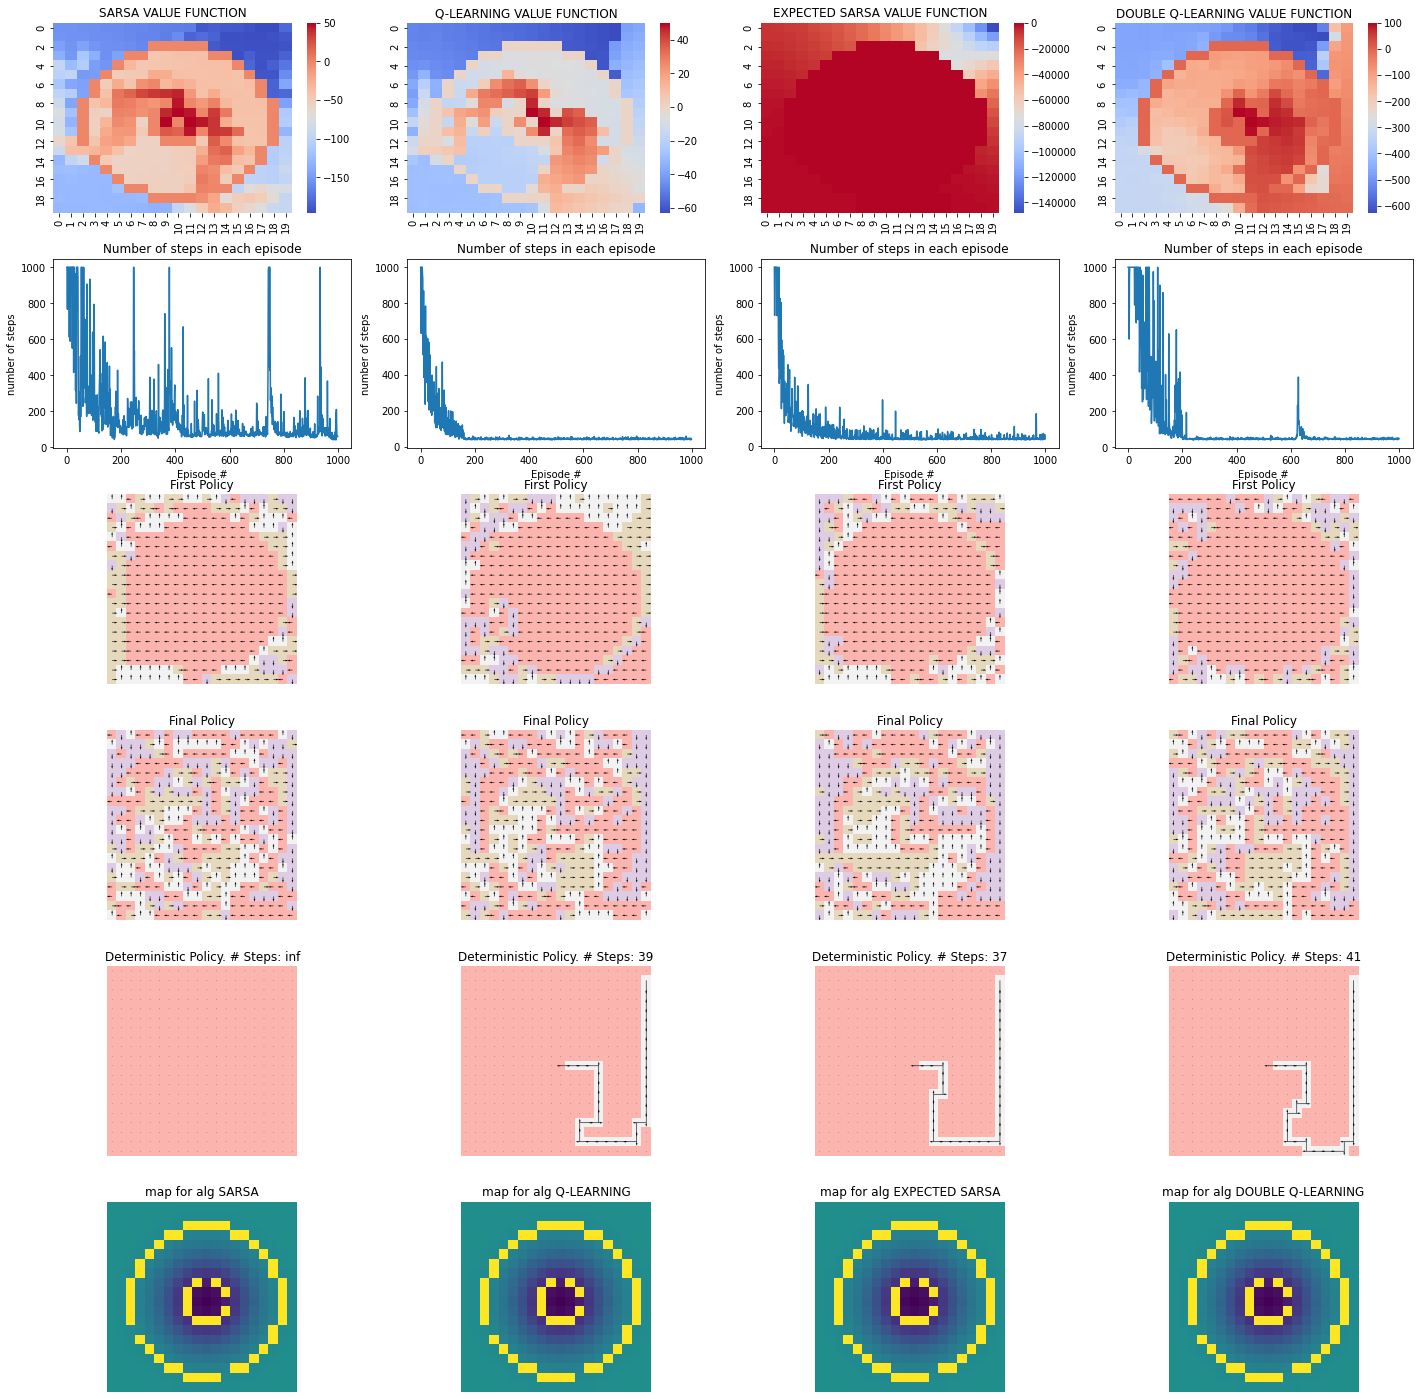

In [ ]:
from tqdm.auto import tqdm

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []
total_maps = []

for ALGORITHM in range(1,5):
    grid = MountainWorld(_wind=False, _changing_wind=False)
    total_maps.append(grid.get_world_map())
    counts = []
    for i in tqdm(range(grid.N_EPISODES), desc=f'Progress for {algs[ALGORITHM-1]}'):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        time_steps = 0

        while not state == grid.FIN_STATE and time_steps < grid.MAX_TIME_STEPS:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action, time_steps)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action, time_steps)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action, time_steps)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action, time_steps)

            action = next_action
            state = next_state

            time_steps += 1
        if i == 0:
            first_policy = grid.compute_actions()
        counts.append(time_steps)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)

GeneralPlot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid, total_maps)

We can already see how this setting maybe is a little too ambicious for these four algorithms. As rewards get more negative towards the center of the grid, the algorithms will try to "avoid" the center, which is exactly the opposite to what we want them to do. Either way, it seems like in some runs, we are lucky and all three algorithms get to the center, in a number of steps between 30 and 60.

### Windy mountain

We now try the same test, but this time, the world has some downward constant wind that will alter the agent's movements.

Progress for SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for Q-LEARNING:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for EXPECTED SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for DOUBLE Q-LEARNING:   0%|          | 0/1000 [00:00<?, ?it/s]

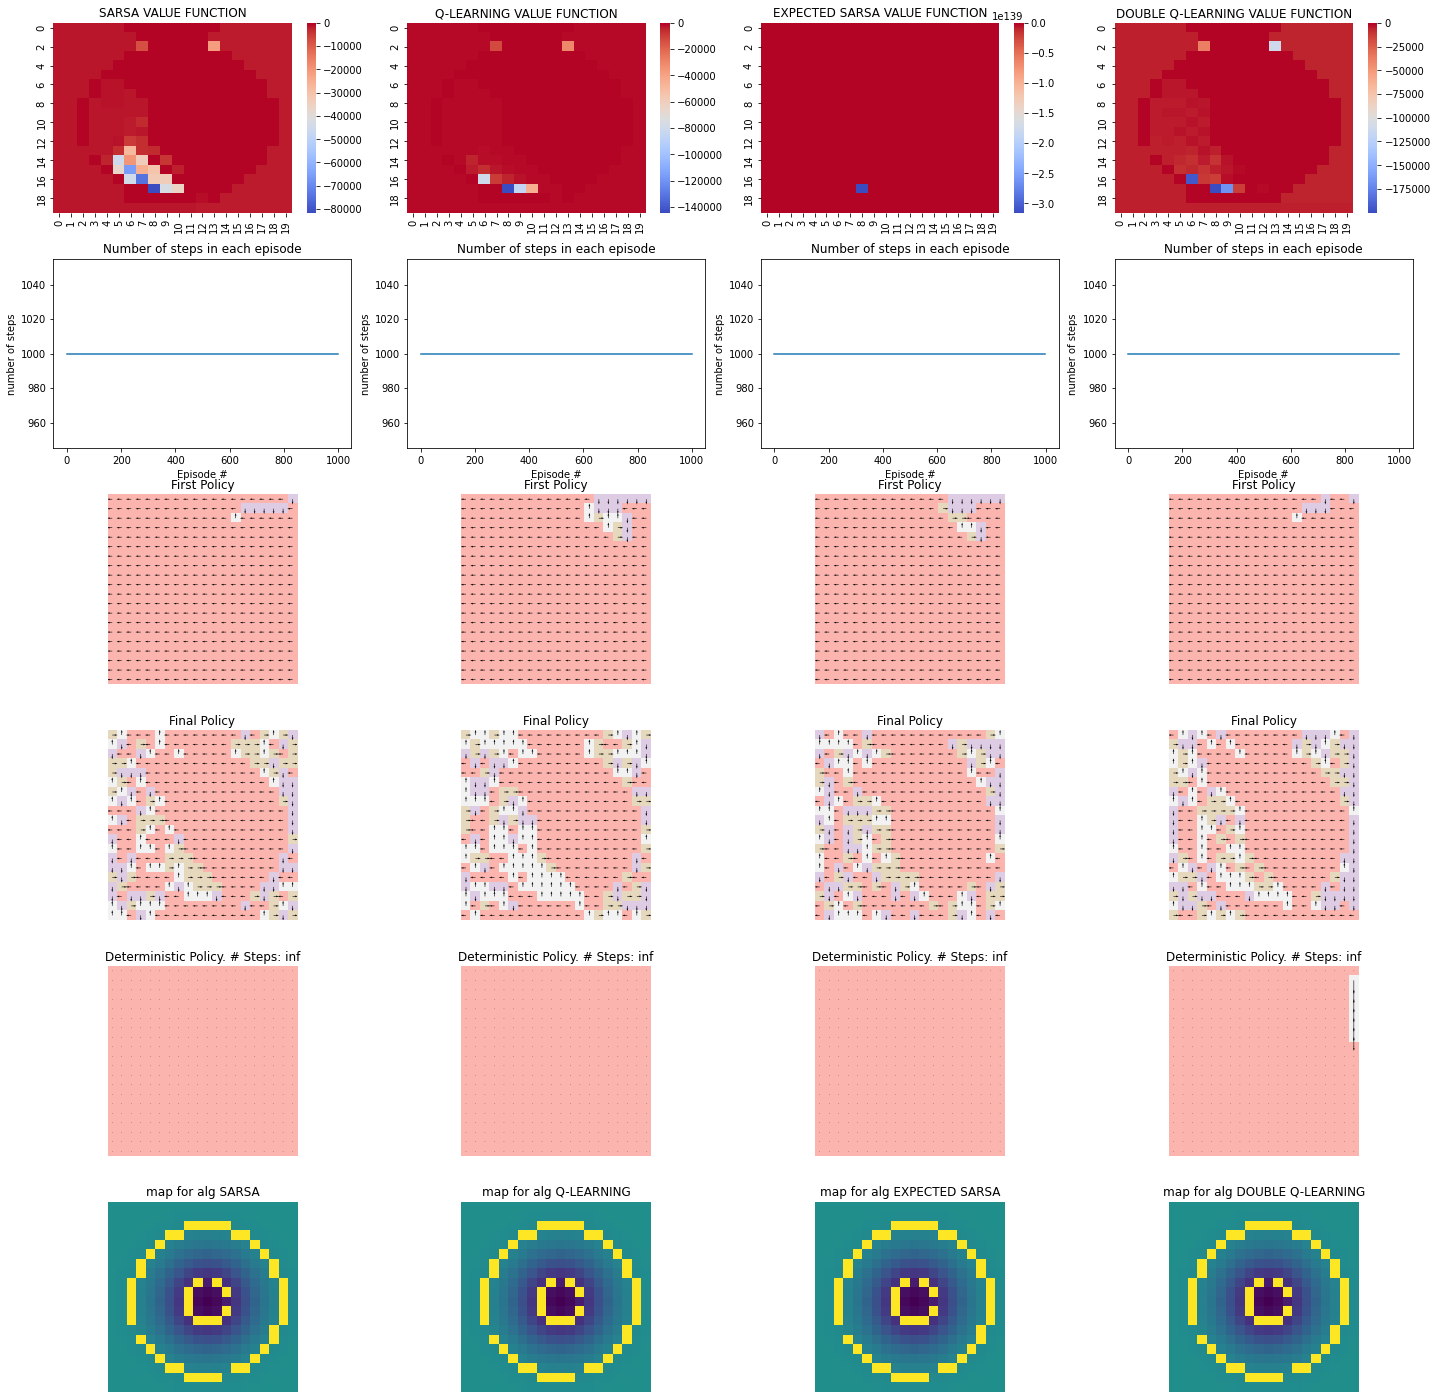

In [ ]:
from tqdm.auto import tqdm

total_counts = []
total_v_funs = []
total_first_p = []
total_final_p = []
total_determ_p = []
total_steps = []
total_maps = []

for ALGORITHM in range(1,5):
    grid = MountainWorld(_wind=True, _changing_wind=False)
    total_maps.append(grid.get_world_map())
    counts = []
    for i in tqdm(range(grid.N_EPISODES), desc=f'Progress for {algs[ALGORITHM-1]}'):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        time_steps = 0

        while not state == grid.FIN_STATE and time_steps < grid.MAX_TIME_STEPS:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action, time_steps)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action, time_steps)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action, time_steps)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action, time_steps)

            action = next_action
            state = next_state

            time_steps += 1
        if i == 0:
            first_policy = grid.compute_actions()
        counts.append(time_steps)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)

GeneralPlot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid, total_maps)

In the resulting visualizations, we can see that most of the time, the algorithms fail to address the task correctly. In fact, with a greedy action selection derived from their last policy, they seem to not get to the terminal state, the peak of the mountain, at all. This may happen because the wind makes the agent bump into walls and get negative reward so much that it goes "crazy", in a very human-like sense, and starts to not know what to do.

Maybe a good thing to add here could be the "do nothing" action, which would let the agent decide not to move and instead let the wind move it.

### Chaos windy mountain world

Now we try with vertical changing wind, where the change itself obeys the following equation,
$$
W(x,t)=\sin{\left(\frac{\pi}{2} t\right)}\cdot s(x),
$$
where $x$ is the column of the current state, and $s(x)$ is the strength of the wind at column $x$.

Progress for SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for Q-LEARNING:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for EXPECTED SARSA:   0%|          | 0/1000 [00:00<?, ?it/s]

Progress for DOUBLE Q-LEARNING:   0%|          | 0/1000 [00:00<?, ?it/s]

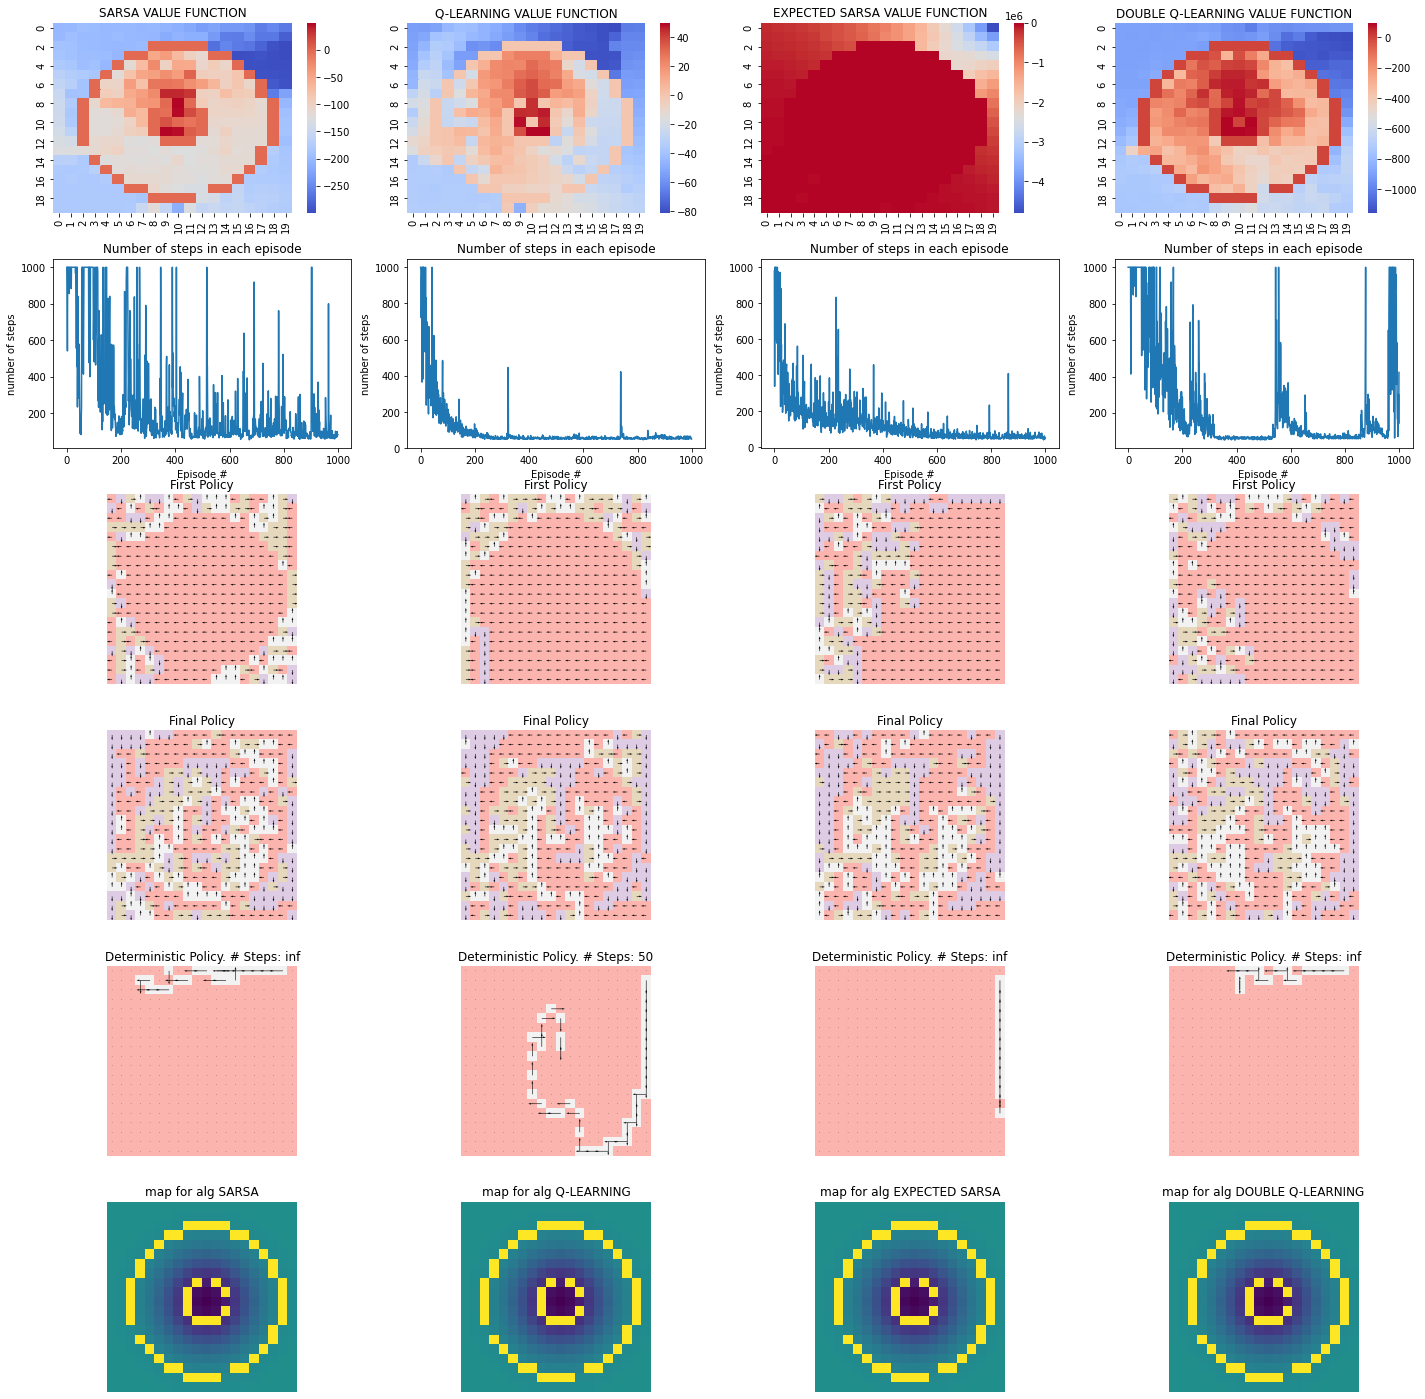

In [ ]:
from tqdm.auto import tqdm

total_counts   = []
total_v_funs   = []
total_first_p  = []
total_final_p  = []
total_determ_p = []
total_steps    = []
total_maps     = []

for ALGORITHM in range(1,5):
    grid = MountainWorld(_wind=True, _changing_wind=True)
    total_maps.append(grid.get_world_map())
    counts = []
    for i in tqdm(range(grid.N_EPISODES), desc=f'Progress for {algs[ALGORITHM-1]}'):
        state = grid.INI_STATE
        action = grid.greedy_policy(state)
        time_steps = 0

        while not state == grid.FIN_STATE and time_steps < grid.MAX_TIME_STEPS:

            if ALGORITHM == 1:
                next_state, next_action = grid.sarsa(state, action, time_steps)
            elif ALGORITHM == 2:
                next_state, next_action = grid.q_learning(state, action, time_steps)
            elif ALGORITHM == 3:
                next_state, next_action = grid.expected_sarsa(state, action, time_steps)
            elif ALGORITHM == 4:
                next_state, next_action = grid.double_q_learning(state, action, time_steps)

            action = next_action
            state = next_state

            time_steps += 1
        if i == 0:
            first_policy = grid.compute_actions()
        counts.append(time_steps)
    
    v_fun = grid.compute_v_fun()
    vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
    first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    final_policy = grid.compute_actions(double=True)
    final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
    determ_policy, steps = grid.deterministic_policy()

    total_v_funs.append(vf_matrix)
    total_counts.append(counts)
    total_first_p.append(first_action_arrows)
    total_final_p.append(final_action_arrows)
    total_determ_p.append(determ_policy)
    total_steps.append(steps)

GeneralPlot(total_v_funs, total_counts, total_first_p, total_final_p, total_determ_p, total_steps, grid, total_maps)

We can see that using evolving wind, the results are "better" in the sense that generally, at least one of the algorithms gets to the terminal state. This may be because the wind is changing and sometimes, it is zero (on $t=\dot{2})$, so it lets the algorithm decide "freely" where to go in this time steps.

## Multiple run analysis

### Wind-less alpinism

Given the previous results, we will first analyze the wind-less mountain world, as it is the one that has more set grounds and can be better understood. From experimentation, we will consider that a run is optimal if the number of steps it takes to get to the peak of the mountain is less or equal than 37.

In [ ]:
def test_algorithms(n_runs: int = 25):

    algorithms = ['sarsa', 'q-learning', 'expected sarsa', 'double q-learning']
    total_optimal_runs = {name: 0 for name in algorithms}
    average_steps_per_run = {name: 0 for name in algorithms}
    mean_episodes_until_convergence = {name: 0 for name in algorithms}
    total_episodes_until_convergence = []
    for run in tqdm(range(n_runs), desc='Runs Progress'):
        run_episodes_until_convergence = []
        total_steps = []
        for ALGORITHM in algorithms:
            grid = MountainWorld(_wind=False, _changing_wind=False)
            number_of_episodes_until_convergence = grid.N_EPISODES
            previous_policy = grid.compute_actions()
            policy = grid.compute_actions()
            algorithm_has_converged = False
            average_steps_per_episode = 0
            for episode in range(grid.N_EPISODES):
                policy_stable = True
                state = grid.INI_STATE
                action = grid.greedy_policy(state)
                steps = 0

                while not state == grid.FIN_STATE:

                    if ALGORITHM == 'sarsa':
                        next_state, next_action = grid.sarsa(state, action, steps)
                    elif ALGORITHM == 'q-learning':
                        next_state, next_action = grid.q_learning(state, action, steps)
                    elif ALGORITHM == 'expected sarsa':
                        next_state, next_action = grid.expected_sarsa(state, action, steps)
                    elif ALGORITHM == 'double q-learning':
                        next_state, next_action = grid.double_q_learning(state, action, steps)

                    action = next_action
                    state = next_state
                    steps += 1
                
                # incremental implementation of the mean
                average_steps_per_episode += (steps-average_steps_per_episode)/(episode+1)

                # Upon end of episode, we compute the actions for the newest
                # policy and compare the actions
                previous_policy = policy
                policy = grid.compute_actions(double = ALGORITHM == 'double q-learning')
                for (action_old, action_new) in zip(previous_policy, policy):
                    # If any action is different, we have not yet reached the
                    # optimal policy, hence we are not in a stable point
                    if action_old != action_new:
                        policy_stable = False
                        break
                if policy_stable and not algorithm_has_converged:
                    number_of_episodes_until_convergence = episode
                    algorithm_has_converged = True
                if episode == 0:
                    first_policy = policy
            run_episodes_until_convergence.append(number_of_episodes_until_convergence)
            
            v_fun = grid.compute_v_fun()
            vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
            first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
            final_policy = grid.compute_actions(double=True)
            final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
            determ_policy, steps = grid.deterministic_policy()

            total_steps.append(steps)
            if steps != 'inf' and int(steps) <= 37:
                # After the whole run (grid.N_EPISODES episodes) we have learnt
                # the optimal policy, hence this is an optimal run
                total_optimal_runs[ALGORITHM] += 1/n_runs
            average_steps_per_run[ALGORITHM] += (average_steps_per_episode-average_steps_per_run[ALGORITHM])/(run+1)
        total_episodes_until_convergence.append(run_episodes_until_convergence)


    eps = np.mean(total_episodes_until_convergence, axis=0)
    for i in range(4):
        mean_episodes_until_convergence[algorithms[i]] = eps[i]

    return {'optimal_runs': total_optimal_runs, 'convergence': mean_episodes_until_convergence, 'average_steps': average_steps_per_run}

We will test the algorithms with just 25 runs, as if we do not do it like this (and even doing it like this), we can and have run, through experimentation, into serious overflow problems. These could have maybe been solved by reducing the maximum number of steps allowed, but then, this leaves little room for the algorithms to have chances of getting to the center of the grid, and hence this alone would hinder a lot their ability to learn from the environment, so that is a no-go. So, let us present our results with 30 runs of each algorithm.

In [ ]:
data = test_algorithms()
optimal_runs_data = data['optimal_runs']
convergence_data  = data['convergence']
steps_data        = data['average_steps']

import altair as alt
import pandas as pd

df_optimal = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(optimal_runs_data.values())})
ch1 = alt.Chart(df_optimal).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(format='%', title='(average) Percentage of optimal runs'))
).properties(
    width=400
)

df_convergence = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(convergence_data.values())})
ch2 = alt.Chart(df_convergence).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(title='(average) Episodes until convergence'))
).properties(
    width=400
)

df_steps = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(steps_data.values())})
ch3 = alt.Chart(df_steps).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(title='(average) Steps per episode'))
).properties(
    width=400
)

ch1 | ch2 | ch3

Runs Progress:   0%|          | 0/25 [00:00<?, ?it/s]

alt.HConcatChart(...)

As we can see in the first graphic, Q-Learning outperforms the other algorithms by far, and SARSA here is clearly at a disadvantage when it comes to the fraction of runs that were optimal. As for convergence and average number of steps per episode, in this custom GridWorld implementation we have a clear winner also, this being Q-Learning again. It looks like Q-Learning is nicely suited for this situation, or at least better suited than the other algorithms, though it should be completely confirmed by a larger set of repetitions of the four algorithms.

It is curious, and unexpected in light of the previous discussion, to see how SARSA does converge to a policy but does not get any optimal run at all. 

### Chaos windy mountain world

And last but not least, to test the evolving wind mountain world we will consider a run to be not optimal, but "good enough", when it takes less than 50 steps to get to the peak with its last policy. We will try to analyze policy convergence, but this may be to no avail.

In [ ]:
def test_algorithms(n_runs: int = 25):

    algorithms = ['sarsa', 'q-learning', 'expected sarsa', 'double q-learning']
    total_optimal_runs = {name: 0 for name in algorithms}
    average_steps_per_run = {name: 0 for name in algorithms}
    mean_episodes_until_convergence = {name: 0 for name in algorithms}
    total_episodes_until_convergence = []
    for run in tqdm(range(n_runs), desc='Runs Progress'):
        run_episodes_until_convergence = []
        total_steps = []
        for ALGORITHM in algorithms:
            grid = MountainWorld(_wind=True, _changing_wind=True)
            number_of_episodes_until_convergence = grid.N_EPISODES
            previous_policy = grid.compute_actions()
            policy = grid.compute_actions()
            algorithm_has_converged = False
            average_steps_per_episode = 0
            for episode in range(grid.N_EPISODES):
                policy_stable = True
                state = grid.INI_STATE
                action = grid.greedy_policy(state)
                steps = 0

                while not state == grid.FIN_STATE:

                    if ALGORITHM == 'sarsa':
                        next_state, next_action = grid.sarsa(state, action, steps)
                    elif ALGORITHM == 'q-learning':
                        next_state, next_action = grid.q_learning(state, action, steps)
                    elif ALGORITHM == 'expected sarsa':
                        next_state, next_action = grid.expected_sarsa(state, action, steps)
                    elif ALGORITHM == 'double q-learning':
                        next_state, next_action = grid.double_q_learning(state, action, steps)

                    action = next_action
                    state = next_state
                    steps += 1
                
                # incremental implementation of the mean
                average_steps_per_episode += (steps-average_steps_per_episode)/(episode+1)

                # Upon end of episode, we compute the actions for the newest
                # policy and compare the actions
                previous_policy = policy
                policy = grid.compute_actions(double = ALGORITHM == 'double q-learning')
                for (action_old, action_new) in zip(previous_policy, policy):
                    # If any action is different, we have not yet reached the
                    # optimal policy, hence we are not in a stable point
                    if action_old != action_new:
                        policy_stable = False
                        break
                if policy_stable and not algorithm_has_converged:
                    number_of_episodes_until_convergence = episode
                    algorithm_has_converged = True
                if episode == 0:
                    first_policy = policy
            run_episodes_until_convergence.append(number_of_episodes_until_convergence)
            
            v_fun = grid.compute_v_fun()
            vf_matrix = np.transpose(np.reshape(v_fun, (grid.N_ROWS, grid.N_COLUMNS)))
            first_action_arrows = np.transpose(np.array(first_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
            final_policy = grid.compute_actions(double=True)
            final_action_arrows = np.transpose(np.array(final_policy).reshape(grid.N_ROWS,grid.N_COLUMNS))
            determ_policy, steps = grid.deterministic_policy()

            total_steps.append(steps)
            if steps != 'inf' and int(steps) <= 50:
                # After the whole run (grid.N_EPISODES episodes) we have learnt
                # the optimal policy, hence this is an optimal run
                total_optimal_runs[ALGORITHM] += 1/n_runs
            average_steps_per_run[ALGORITHM] += (average_steps_per_episode-average_steps_per_run[ALGORITHM])/(run+1)
        total_episodes_until_convergence.append(run_episodes_until_convergence)


    eps = np.mean(total_episodes_until_convergence, axis=0)
    for i in range(4):
        mean_episodes_until_convergence[algorithms[i]] = eps[i]

    return {'optimal_runs': total_optimal_runs, 'convergence': mean_episodes_until_convergence, 'average_steps': average_steps_per_run}

In [ ]:
data = test_algorithms()
optimal_runs_data = data['optimal_runs']
convergence_data  = data['convergence']
steps_data        = data['average_steps']

import altair as alt
import pandas as pd

df_optimal = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(optimal_runs_data.values())})
ch1 = alt.Chart(df_optimal).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(format='%', title='(average) Percentage of optimal runs'))
).properties(
    width=400
)

df_convergence = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(convergence_data.values())})
ch2 = alt.Chart(df_convergence).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(title='(average) Episodes until convergence'))
).properties(
    width=400
)

df_steps = pd.DataFrame({'names': ['SARSA', 'QL', 'E-SARSA', 'DQL'],
                     'values': list(steps_data.values())})
ch3 = alt.Chart(df_steps).mark_bar().encode(
    x = alt.X('names:N', axis=alt.Axis(title='Algorithm')),
    y = alt.Y('values:Q', axis=alt.Axis(title='(average) Steps per episode'))
).properties(
    width=400
)

ch1 | ch2 | ch3

Runs Progress:   0%|          | 0/25 [00:00<?, ?it/s]

alt.HConcatChart(...)

Once again, Q-Learning is a clear winner here in all aspects (performance, convergence, and average steps). We can see how all the algorithms we were using in the wind-less case have decreased their performance (except for SARSA, which could not reduce it more) and increased both steps per episode and episodes until convergence.